# **Player Ranking and Rating Analyses**

We'll explore who's occupied the number one rank over time and who's had the best Elo Ratings. First we pull in the data and import the libraries we need. Note that we create a quick SQL database to easily join and limit the data in the way we want. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
import datetime

In [4]:
import pickle
with open('/content/drive/My Drive/ATP Tennis/Database/ATP_Pickle.pickle','rb') as f:
    atp_pickle = pickle.load(f)

connection = sqlite3.connect('/content/drive/My Drive/ATP Tennis/Database/ATP_Tennis.db')
c = connection.cursor()
atp_pickle[0].to_sql('ATP_MATCHES', connection, if_exists='replace', index = False)
atp_pickle[1].to_sql('ATP_PLAYERS', connection, if_exists='replace', index = False)
atp_pickle[2].to_sql('ATP_RANKINGS', connection, if_exists='replace', index = False)

We'll query which players were ranked number 1 count how many weeks they held the top spot. Note that the ranking data is at the weekly level and is incomplete before 1985.  We see that Federer tops the list followed by Sampras, Djokovic, Lendel, and Nadal. The Elo ratings allow us to see better who was on top across the entire date range (1968-2020). We'll get to this soon.

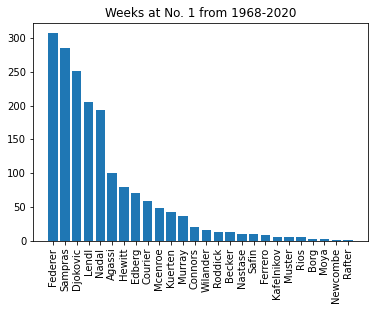

In [6]:
c.execute('''
SELECT b.first_name, b.last_name, count() as weeks_no_1
FROM ATP_RANKINGS as a, ATP_PLAYERS as b
ON a.player=b.player
WHERE a.rank == 1
GROUP BY b.last_name
ORDER BY -weeks_no_1
''')
No1_Ranked_Players = pd.DataFrame(c.fetchall(),columns=[c.description[i][0] for i in range(len(c.description))])
plt.bar(No1_Ranked_Players["last_name"], No1_Ranked_Players["weeks_no_1"])
plt.title("Weeks at No. 1 from 1968-2020")
plt.xticks(rotation=90)
plt.show()

What is particularly striking is the level of dominance by particular sets of players. We plot the rank of all players that were ranked number 1 for more than 60 weeks. This allows us to see the transition from the 90s era of dominance by Sampras, Agassi, and Hewitt to the modern era dominated by Federer, Nadal, and Djokovic. 

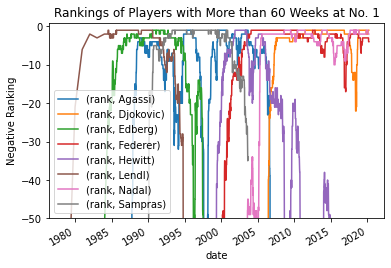

In [7]:
c.execute('''
SELECT a.*, c.last_name
FROM ATP_RANKINGS as a 
INNER JOIN
  (
    SELECT player,count() as weeks_no_1
    FROM ATP_RANKINGS
    WHERE rank==1
    GROUP BY player
    HAVING weeks_no_1>60
  ) as b 
ON a.player=b.player 
INNER JOIN ATP_PLAYERS as c
ON a.player=c.player 
ORDER BY a.ranking_date
''')
No1_Ranked_Players = pd.DataFrame(c.fetchall(),columns=[c.description[i][0] for i in range(len(c.description))])
No1_Ranked_Players['rank'] = -No1_Ranked_Players['rank']
No1_Ranked_Players['date'] = [datetime.date(year=i,day=j,month=k) for i,j,k in zip(No1_Ranked_Players['year'],No1_Ranked_Players['day'],No1_Ranked_Players['month'])]
No1_Ranked_Players = No1_Ranked_Players.pivot(index='date',columns='last_name')[['rank']]
No1_Ranked_Players.plot()
plt.ylim(-50,1)
plt.title("Rankings of Players with More than 60 Weeks at No. 1")
plt.ylabel("Negative Ranking")
plt.legend()
plt.show()

Now we'll look at this from the perspective of Elo rating, we define a function to get the Elo ratings for all of a player's matches. We then use this to get the Elo ratings for the big four and plot their ratings across matches. We see roughly the same trajectories as does this [article](https://fivethirtyeight.com/features/djokovic-and-federer-are-vying-to-be-the-greatest-of-all-time/). So we're on the right track. Note that the article is from 2015 and so has less data than we do. Note that my Elo method is not attempting to replicate this article or any other previous Elo system. So while trajectories are similar, they are not idenitcal. 

This chart shows us very clearly the different eras of the open era of men's tennis. Connors and Borg handed the mantle to McEnroe and Lendl, who in turn were overtaken by Sampras and Agassi. And finally Federer, Nadal, Djokovic and Murray arrived. There were of course other players that also reached high peaks, like Hewitt, Edberg, and Courier, but not for as long nor as high.  

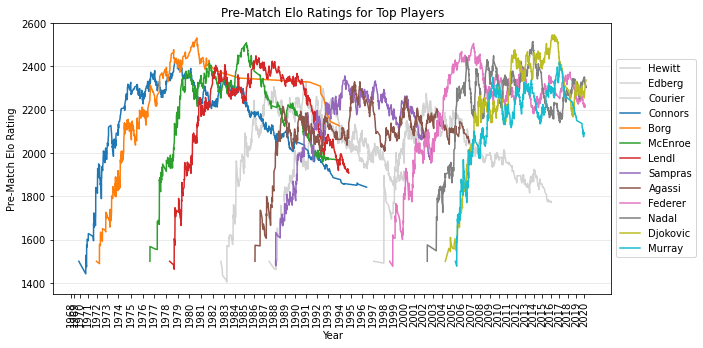

In [8]:
Matches = atp_pickle[0]

def getPlayerEloData(player):
  ply_wins = Matches[Matches["winner_name"]==player]
  ply_loss = Matches[Matches["loser_name"]==player]
  ply_wins = ply_wins[["MatchEloID","year","winner_name","PreMatchElo_Winner_All","PreMatchCount_Winner_All"]]
  ply_loss = ply_loss[["MatchEloID","year","loser_name","PreMatchElo_Loser_All","PreMatchCount_Loser_All"]]
  ply_WL = pd.concat([ply_wins,ply_loss]).sort_values(by="MatchEloID")
  ply_WL["PreMatchElo"] = np.where(ply_WL["PreMatchElo_Winner_All"].notnull(),ply_WL["PreMatchElo_Winner_All"],ply_WL["PreMatchElo_Loser_All"])
  ply_WL["PreMatchCount"] = np.where(ply_WL["PreMatchCount_Winner_All"].notnull(),ply_WL["PreMatchCount_Winner_All"],ply_WL["PreMatchCount_Loser_All"])
  return ply_WL[["MatchEloID","year","PreMatchElo","PreMatchCount"]]

JC = getPlayerEloData("Jimmy Connors")
BB = getPlayerEloData("Bjorn Borg")
JM = getPlayerEloData("John McEnroe")
IL = getPlayerEloData("Ivan Lendl")
PS = getPlayerEloData("Pete Sampras")
AA = getPlayerEloData("Andre Agassi")
RF = getPlayerEloData("Roger Federer")
RN = getPlayerEloData("Rafael Nadal")
ND = getPlayerEloData("Novak Djokovic")
AM = getPlayerEloData("Andy Murray")

LH = getPlayerEloData("Lleyton Hewitt")
SE = getPlayerEloData("Stefan Edberg")
JC2 = getPlayerEloData("Jim Courier")

min_id_by_year = pd.DataFrame(Matches.groupby('year')['MatchEloID'].agg('min'))
min_id_by_year['year'] = min_id_by_year.index

plt.figure(figsize=(10,5))

plt.plot(LH["PreMatchElo"],label="Hewitt",color="lightgrey")
plt.plot(SE["PreMatchElo"],label="Edberg",color="lightgrey")
plt.plot(JC2["PreMatchElo"],label="Courier",color="lightgrey")

plt.plot(JC["PreMatchElo"],label="Connors")
plt.plot(BB["PreMatchElo"],label="Borg")
plt.plot(JM["PreMatchElo"],label="McEnroe")
plt.plot(IL["PreMatchElo"],label="Lendl")
plt.plot(PS["PreMatchElo"],label="Sampras")
plt.plot(AA["PreMatchElo"],label="Agassi")
plt.plot(RF["PreMatchElo"],label="Federer")
plt.plot(RN["PreMatchElo"],label="Nadal")
plt.plot(ND["PreMatchElo"],label="Djokovic")
plt.plot(AM["PreMatchElo"],label="Murray")

plt.title("Pre-Match Elo Ratings for Top Players")
plt.ylabel("Pre-Match Elo Rating")
plt.xlabel("Year")
plt.xticks(min_id_by_year['MatchEloID'],min_id_by_year['year'],rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis="y",alpha=0.3)
plt.show()

Next, we plot Elo ratings by age for all players, highlighting the best players. We see that the best players are dominant before age 20 and tend to stay that way, with Elo ratings rarely dipping below 2000.

In [ ]:
winners = Matches[["MatchEloID",
                   "year",
                   "winner_id",
                   "winner_name",
                   "winner_age",
                   "winner_rank",
                   "PreMatchElo_Winner_All"]]
winners["win"] = 1
winners = winners.rename(columns={"winner_id": "id", 
                                  "winner_name": "name", 
                                  "winner_age": "age", 
                                  "winner_rank": "rank", 
                                  "PreMatchElo_Winner_All": "PreMatchElo"})

losers = Matches[["MatchEloID",
                  "year",
                  "loser_id",
                  "loser_name",
                  "loser_age",
                  "loser_rank",
                  "PreMatchElo_Loser_All"]]
losers["win"] = 0
losers = losers.rename(columns={"loser_id": "id", 
                                "loser_name": "name", 
                                "loser_age": "age", 
                                "loser_rank": "rank", 
                                "PreMatchElo_Loser_All": "PreMatchElo"})

all = pd.concat([winners,losers]).sort_values(by=["MatchEloID","win"]).reset_index()
all = all[all["age"].notnull()]

mins = pd.DataFrame(all.groupby('id')[['year','age']].agg('min'))
mins["start_half_decade"] = np.floor((mins["year"]-1990)/5)*5 + 1990
mins['id'] = mins.index

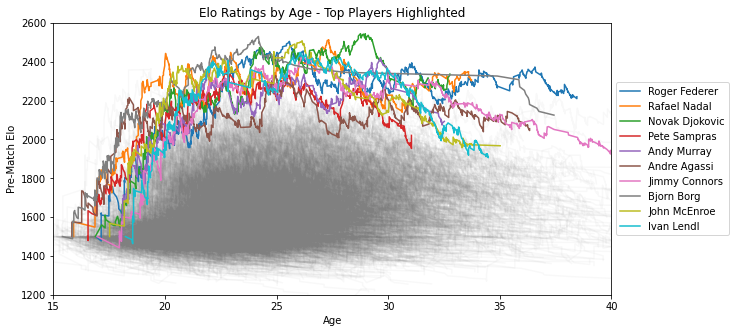

In [10]:
plt.figure(figsize=(10,5))

for id in list(mins['id']):
  player = all[all["id"]==id].sort_values(by="MatchEloID").set_index("age")
  plt.plot(player["PreMatchElo"],c="grey",alpha=0.05)
for name in ["Roger Federer","Rafael Nadal","Novak Djokovic","Pete Sampras","Andy Murray","Andre Agassi","Jimmy Connors","Bjorn Borg","John McEnroe","Ivan Lendl"]:
  player = all[all["name"]==name].sort_values(by="MatchEloID").set_index("age")
  plt.plot(player["PreMatchElo"],label=name)

plt.xlim(15,40)
plt.ylim(1200,2600)
plt.legend(loc="lower right")
plt.title("Elo Ratings by Age - Top Players Highlighted")
plt.xlabel("Age")
plt.ylabel("Pre-Match Elo")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()